### Packages and Imports

In [1]:
import torch
import pandas as pd
import numpy as np

from datetime import datetime
from matplotlib import pyplot as plt

from utils.instruments import Stock, RiskFactor
from utils.data_handler import YahooDataHandler
from models.ar import AR
from models.garch import GARCH

%config InlineBackend.figure_format = 'retina'
plt.style.use(['science', 'notebook', 'grid'])

### Financial Data

In [2]:
ydh = YahooDataHandler()

ticker = "GS"

# Start and end dates.
start = datetime.strptime("2005-05-01", r"%Y-%m-%d")
end = datetime.strptime("2023-06-01", r"%Y-%m-%d")

price_history = ydh.get_price_history(ticker, start, end)
identifier = f"{ticker}_RF"
risk_factor = RiskFactor(identifier, price_history)
stock = Stock(identifier=ticker, risk_factors=[risk_factor])

data = risk_factor.price_history.log_returns

[*********************100%***********************]  1 of 1 completed


In [3]:
ar_model = AR(data)
ar_model.calibrate()
print(ar_model.parameters)

[-0.05507304146885872, 0.0038949972949922085, 0.00031815917463973165, 0.022512583062052727]


In [4]:
ar_model.aic

tensor(-24765.1289)

In [5]:
ar_model.bic

tensor(-24739.4355)

In [6]:
garch_model = GARCH(data)
garch_model.calibrate()

In [7]:
torch.sqrt(garch_model._long_run_variance) * 100

tensor(2.2510)

tensor(1.6208)

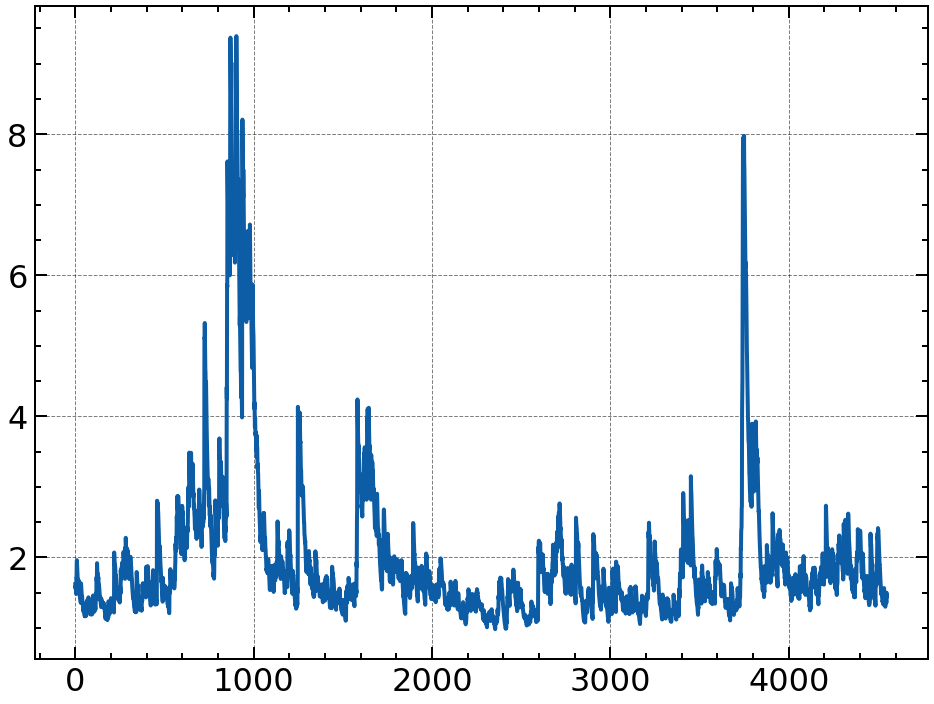

In [8]:
garch_model._solution
vol = garch_model._compute_variance(parameters=torch.tensor(garch_model._solution.x))
plt.plot(torch.sqrt(vol)*100)
torch.sqrt(garch_model._initial_variance) * 100

In [9]:
garch_model._solution

      fun: -32102.430924834698
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.00695232e-05, -3.91944590e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 10
      nit: 9
     njev: 10
   status: 0
  success: True
        x: array([4.45566677, 2.47338611])

In [10]:
ar_model._log_likelihood

tensor(12386.5645)

In [11]:
torch.tensor([1,2]).numpy()

array([1, 2])

In [12]:
garch_model._solution.fun

-32102.430924834698

In [13]:
garch_model.aic

tensor(-23732.2539)

In [14]:
garch_model.bic

tensor(-23712.9844)

In [15]:
ar_model.bic

tensor(-24739.4355)

In [16]:
ar_model.aic

tensor(-24765.1289)

In [17]:
ar_model._log_likelihood

tensor(12386.5645)

In [18]:
garch_model._log_likelihood

tensor(11869.1270)

In [19]:
garch_model._solution.fun

-32102.430924834698

In [20]:
garch_model.transform_to_uniform()

tensor([0.4788, 0.8757, 0.2826,  ..., 0.9655, 0.4060, 0.1744])

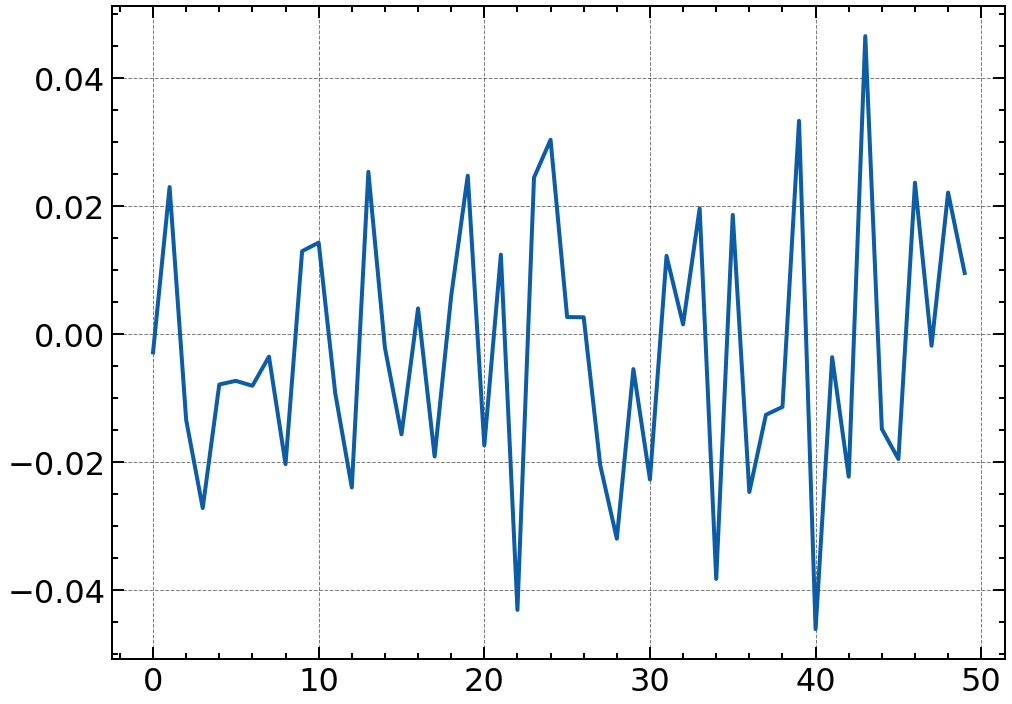

In [77]:
from torch.distributions import Uniform


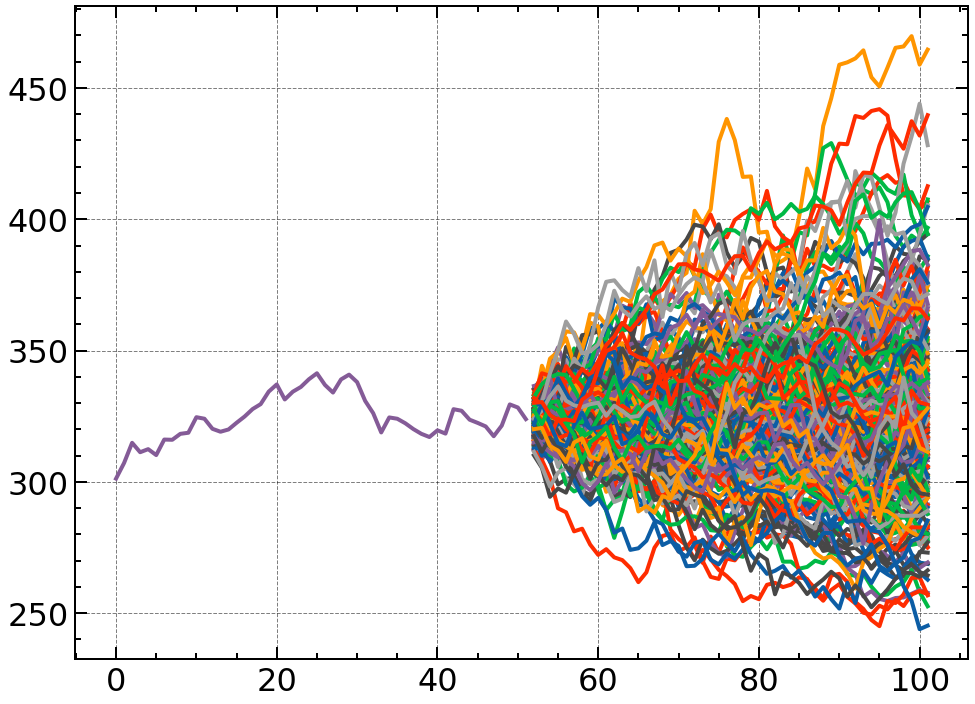

In [80]:
for _ in range(200):
    S0 = torch.tensor(price_history.mid_history[-1])
    randoms = Uniform(0, 1).rsample((50,))
    returns = garch_model.transform_to_true(randoms)

    t1 = range(len(price_history.mid_history[4500:]))
    t2 = range(len(t1), len(returns)+len(t1))
    plt.plot(t2, torch.exp(torch.cumsum(returns, dim=0)) * S0)
plt.plot(t1, price_history.mid_history[4500:])
    

In [81]:
garch_model.aic

tensor(-23732.2539)

In [82]:
garch_model.bic

tensor(-23712.9844)

In [83]:
garch_model._log_likelihood

tensor(11869.1270)

In [92]:
import arch
model = arch.arch_model(data*100, vol='GARCH', p=1, q=1)
results = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 303925179895.094
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4602165312.340242
Iteration:      3,   Func. Count:     22,   Neg. LLF: 999040368.3878915
Iteration:      4,   Func. Count:     28,   Neg. LLF: 12798.321014940671
Iteration:      5,   Func. Count:     36,   Neg. LLF: 9112.756771985652
Iteration:      6,   Func. Count:     42,   Neg. LLF: 16601.622245988285
Iteration:      7,   Func. Count:     48,   Neg. LLF: 9096.26093603509
Iteration:      8,   Func. Count:     54,   Neg. LLF: 9084.714721524695
Iteration:      9,   Func. Count:     59,   Neg. LLF: 9084.701428361892
Iteration:     10,   Func. Count:     64,   Neg. LLF: 9084.700915361316
Iteration:     11,   Func. Count:     69,   Neg. LLF: 9084.700890099706
Iteration:     12,   Func. Count:     73,   Neg. LLF: 9084.700890102991
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9084.700890099706
            Iterations: 12
 

In [93]:
results.bic

18203.09418927148

In [94]:
results.params

mu          0.063784
omega       0.064033
alpha[1]    0.077453
beta[1]     0.907071
Name: params, dtype: float64

In [99]:
torch.mean(torch.tensor(data))*100

tensor(0.0306, dtype=torch.float64)